# Alternativas para migrar packages / procedimientos almacenados a HDFS
 
 
## Librería HPL / SQL

Traductor de codigo SQL a Apache Hive y Microsoft SQL Server, o  Transact-SQL en Oracle, Cloudera Impala o Amazon Redshift.
#### Instalación en sistemas unix
```
   wget http://www.hplsql.org/downloads/hplsql-0.3.31.tar.gz
    gunzip hplsql-0.3.31.tar.gz 
    tar -xvf hplsql-0.3.31.tar 
    cd hplsql-0.3.31
    export HADOOP_CLASSPATH=`hadoop classpath`
    ./hplsql --version
    ./hplsql -e "select * from employees"
```
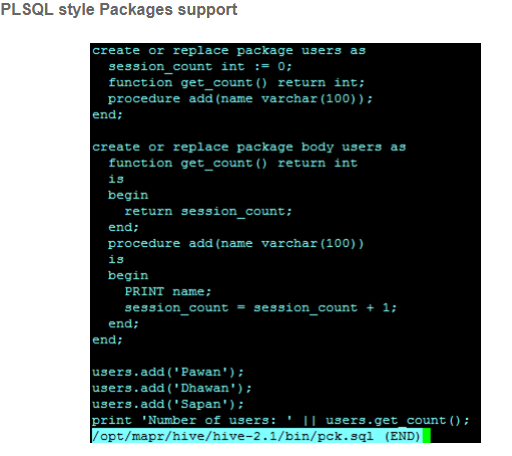
http://agnihotripawan.blogspot.com/2017/10/hplsql-procedural-sql-on-hadoop.html
><p>It's not included with Hive 1.1.0 (CDH 5's version of Hive), but is downloadable and usable as a separate package. Note that it's helpful for porting, but it's not optimized like Oracle PL/SQL would be when run in an Oracle DB, or like a Spark job would be when run on a cluster.</p>


- Ver: http://www.hplsql.org/doc#functions


## Big Data Oracle

Try using “Oracle Big Data SQL” in case your legacy DB is Oracle. It works like a charm and you will be able to execute PLSQL queries and stored procedures on Hive using it. This is the approach which I took.


- oracle integrador 
http://www.oracle.com/us/products/middleware/data-integration/hadoop/overview/index.html

https://www.quora.com/How-do-I-replace-Oracle-PL-SQL-application-with-Big-data-tools-like-Hive-and-Spark


##  UDF - Funciones definidas por usuario
Estas realmente no son SP  pero permiten definir la logica en java.

```
 protected ResultSet fetchDataFromJdbc(String storedProc) {
   Connection connection;
   CallableStatement statement;

   try {
     Class.forName("my.db.Driver");

     connection = DriverManager.getConnection("url","user","pass");

     statement = connection.prepareCall(storedProc);
     statement.registerOutParameter(1, "outValue");
     statement.executeQuery();

     return (ResultSet) statement.getObject(1);
   } catch (Exception e) {
         e.printStackTrace();
         log.error(e.getMessage());
   }

 throw new IllegalStateException("Results should have returned.");
}
```

```
    from pyspark.sql.types import StringType
    from pyspark.sql.functions import udf
    F1 = udf(lambda x: '-1' if x in not_found_cat else x, StringType())

```


https://stackoverflow.com/questions/46735996/convert-oracle-stored-procedure-to-hive-or-spark



## Carga desde archivos

Esta opcion permite cargar los achivos sql con java y enviarlos a Hive para completar los parametros de entrada. 


## Uso de Vistas

Almacenadas en la BD

## Migracion de datos con Oracle GoldenGate (licencia)
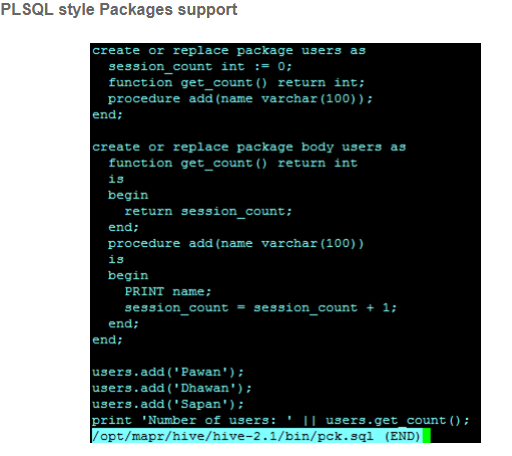
 
#### Características clave:

- El movimiento de datos es en tiempo real, reduciendo la latencia.

- Solo se mueven las transacciones comprometidas, lo que permite la consistencia y mejora el rendimiento.

- Se admiten diferentes versiones y versiones de Oracle Database junto con una amplia gama de bases de datos heterogéneas que se ejecutan en una variedad de sistemas operativos. Puede replicar datos de una base de datos Oracle a una base de datos heterogénea diferente.

- Arquitectura simple y fácil configuración.

- Alto rendimiento con una sobrecarga mínima en las bases de datos e infraestructura subyacentes.

Ver : 

http://www.oracle.com/us/products/middleware/data-integration/goldengate-for-big-data-ds-2415102.pdf

Implementaciones :

http://www.ateam-oracle.com/oracle-goldengate-big-data-apply-to-apache-hdfs/

Descargas : 

https://www.oracle.com/technetwork/middleware/goldengate/downloads/index.html


##  Spark SQL   

Con Spark SQL es posible ejecutar sentencias de codigo SQL gracias a su API , permitiendo unificar los datos de diferentes entornos y sistemas de almacenamiento.

#### Bloque de código SQL 
```sql
    SELECT Nvl(SUM(cucovato - cucovaab - cucovare), 0) AS total
    FROM   chilquin.cuencobr a
    WHERE  a.cucofact = 20031385
           AND a.cucosacu IS NOT NULL
           AND a.cucovato - a.cucovaab - a.cucovare > 0
           AND a.cucoesta = 'F' 
```
#### Bloque de funcion encapsulada
```sql
SELECT CHQ_PRUEBAS_BIGDATA.obt_saldo(47090846) AS total from dual
```
https://stackoverflow.com/questions/21393906/how-to-invoke-a-pl-sql-procedure-stored-on-an-oracle-database-from-r/44543699


### Entorno de trabajo 

- Windows 10  
- Anaconda
- Jupyter con kernel Spark  
- Python 3


### Llamada al cluster Spark

In [1]:
from pyspark.sql import SparkSession , SQLContext, Row
spark = SparkSession.builder.appName("Ejemplo Spark SQL con Python").getOrCreate()

Definiedo la consulta y el driver al Oracle

In [2]:
# Código SQL
consulta = "(SELECT nvl(sum(CUCOVATO - CUCOVAAB -CUCOVARE),0) as total FROM    CHILQUIN.CUENCOBR a WHERE 	a.CUCOFACT = 20031385AND   a.CUCOSACU IS NOT NULL AND   	a.CUCOVATO - a.CUCOVAAB - a.CUCOVARE > 0 AND   	a.CUCOESTA='F' ) tabla"

df = spark.read.format("jdbc").options(url="jdbc:oracle:thin:@143.47.42.204:1521:SFOA0708", 
      dbtable = consulta , 
      driver  = "oracle.jdbc.OracleDriver" , 
      user = "usrclic" ,
      password = "chilquinta").load()

In [3]:
df.show()

+---------------+
|          TOTAL|
+---------------+
|4290.0000000000|
+---------------+



In [4]:
# Función encapsulada
consulta = "(SELECT CHQ_PRUEBAS_BIGDATA.obt_saldo(47090846) as total from dual ) final " 

df = spark.read.format("jdbc").options(url="jdbc:oracle:thin:@10.135.30.128:1521:SFTU0708", 
      dbtable=consulta , 
      driver="oracle.jdbc.OracleDriver" , 
      user="SFINTERFAZ" ,
      password="S1C5E5E7CD09797FBE8EF33AAF2E28").load()

In [5]:
df.show()

+---------------+
|          TOTAL|
+---------------+
|3456.0000000000|
+---------------+



#  Consideraciones


###  Transcribir la lógica de los packages a scala o pyspark : 
El flujo de codigo de las operaciones en los RDBMS es muy diferente al flujo de codigo en Spark , no hay una compativilidad asegurada en estos terminos para Spark SQL.
### Diseñar un marco BD   :
Seguir la misma logica de ingenieria inversa para proponer un modelo de datos  y reproducirlo a traves de scripts.
###  Tipos de datos : 
Sera necesario hacer tranformaciones para  trabajar con tipo de datos entre los entornos.
### Ambientes de testing : 
Es importante considerar ciclos de prueba con ayuda de expertos del negocio , para validar los datos finales.
###  Considerar el caos :
Abra muchos casos en los cuales no se lograra un resultado exacto entre aun SP y el codigo Spark. 
Una razon de esto es que los RDBMS estan altamente estructurados y el procesamiento hace que los datos sean utiles . Sin embargo al ocupar grandes almacenes, esta cualidad no se podria asegurar de la misma manera.
 
Extraido de Quora :https://www.quora.com/How-can-I-translate-PL-SQL-procedures-to-Spark-Code